In [28]:
# imports
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from scipy import sparse

# 先把我們需要的函數載入
ws = WS("./data_ckip") # 斷詞
pos = POS("./data_ckip") # 詞性標注
ner = NER("./data_ckip") # 命名實體識別

/Users/chengliang/anaconda3/lib/python3.11/site-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/Users/chengliang/anaconda3/lib/python3.11/site-packages/ckiptagger/model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/Users/chengliang/anaconda3/lib/python3.11/site-packages/ckiptagger/model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.n

In [29]:
def word_segmentation(contents, ws):
    word_sentence_list = ws(contents, 
                        sentence_segmentation=True,
                        segment_delimiter_set={'?', '？', '!', '！', '。', ',','，', ';', ':', '、', ' ', '.'})
    # 標點符號
    punc = ['，', '。', '、', '：', '；', '？', '！', '「', '」', '（', '）', '『', '』', '—', '－', '～', '…', '‧', '《', '》', '〈', '〉', '﹏﹏']
    eng_punc = [',', '.', ':', ';', '?', '!', '(', ')', '[', ']', '&', '@', '#', '$', '%', '-', '_', '*', '/', '\\', '+', '=', '>', '<', '"', "'", '’', '‘', '“', '”', ' ']
    # 停用詞
    stop_words = ['全文', '日', '月', '年', 'br', '中央社', '公司', '上午', '下午', '日期']

    word_sentence_list = [[word for word in sentence if not any(char.isdigit() for char in word)] for sentence in word_sentence_list]
    word_sentence_list = [[word for word in sentence if word not in punc] for sentence in word_sentence_list]
    word_sentence_list = [[word for word in sentence if word not in eng_punc] for sentence in word_sentence_list]
    word_sentence_list = [[word for word in sentence if word not in stop_words] for sentence in word_sentence_list]

    return word_sentence_list


In [30]:
def preprocessing(df, days, ws):
    # df = df[df['label_day' + str(days)] != -1] # 把標籤為 -1 的 row 全部移除
    Y = lambda df, days: df['label_day' + str(days)].tolist() # 提取標籤
    contents = df['content'].tolist() # 提取正文內容
    # 對正文內容進行斷詞
    word_sentence_list = word_segmentation(contents, ws)
    # 取得 1-gram - 3-gram 的 tf-idf 特徵
    tv = TfidfVectorizer(ngram_range=(1, 3))
    tfidf = tv.fit_transform([' '.join(sentence) for sentence in word_sentence_list])
    # 取得前 1000 個特徵
    ch2 = SelectKBest(chi2, k=1000)
    X = ch2.fit_transform(tfidf, Y(df, days))
    # 將 foreign_investor_surplus, investment_trust_surplus, dealer_surplus 加入到 X
    X = sparse.hstack((X, sparse.csr_matrix(df[['foreign_investor_surplus', 'investment_trust_surplus', 'dealer_surplus']])))
    return X, Y(df, days)

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import xgboost as xgb
import numpy as np
import pickle
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler


data = pd.read_csv('../data/news_filtered_merged.csv')

# 將日期欄位轉換為日期時間類型
data['date'] = pd.to_datetime(data['date'])

# 對資料按照日期進行排序
data.sort_values(by='date', inplace=True)

# 定義每個時段的長度（以天為單位）
period_length = 90  # 90天為一個時段

# 初始化結果列表，用於存放每個時段的預測結果和準確率
results = []

# 初始化混淆矩陣
total_conf_matrix = np.zeros((3, 3))

# 設定起始日期為資料中最小日期
start_date = data['date'].min()

# 分段處理資料
with tqdm(total = 8) as pbar:
    while start_date + pd.Timedelta(days=period_length - 1) <= data['date'].max():
        
        # 取得該時段的結束日期
        end_date = start_date + pd.Timedelta(days=period_length - 1)
        
        # 取出該時段的資料
        period_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
        
        # 準備特徵和標籤
        X, y = preprocessing(period_data, 1, ws)

        y = np.ravel(np.array(y))
        y = y + 1

        X = X.toarray()

        # 創建 StandardScaler 實例
        scaler = StandardScaler()
        
        # 對特徵 X 進行標準化   
        X = scaler.fit_transform(X)

        # 切分資料為訓練集和測試集（按照時間順序）
        split_index = int(len(X) * 0.8)  # 取前80%作為訓練集
        X_train, X_test = X[:split_index], X[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]

        # with open("model.pkl", 'rb') as f:
        #     model = pickle.load(f)

        model = xgb.XGBClassifier()
        
        # 訓練模型
        model.fit(X_train, y_train)
        
        # 進行預測
        y_pred = model.predict(X_test)
        
        # 計算準確率
        accuracy = accuracy_score(y_test, y_pred)
        
        # 計算混淆矩陣
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        # 累加混淆矩陣
        total_conf_matrix += conf_matrix
        
        # 記錄結果
        results.append({'Start_Date': start_date, 'End_Date': end_date, 'Accuracy': accuracy})

        # 更新起始日期為下一個時段的起始日期
        start_date = start_date + pd.Timedelta(days=period_length)
        pbar.update(1)

# 輸出結果
for result in results:
    print("Period Start:", result['Start_Date'], "Period End:", result['End_Date'], "Accuracy:", result['Accuracy'])

# 計算總準確率
total_accuracy = sum(result['Accuracy'] for result in results) / len(results)
print("Total accuracy:", total_accuracy)

# 輸出總混淆矩陣
print("Total Confusion Matrix:")
print(total_conf_matrix)


100%|██████████| 8/8 [06:56<00:00, 52.11s/it]

Period Start: 2022-03-01 00:00:00 Period End: 2022-05-29 00:00:00 Accuracy: 0.3876651982378855
Period Start: 2022-05-30 00:00:00 Period End: 2022-08-27 00:00:00 Accuracy: 0.4397905759162304
Period Start: 2022-08-28 00:00:00 Period End: 2022-11-25 00:00:00 Accuracy: 0.2608695652173913
Period Start: 2022-11-26 00:00:00 Period End: 2023-02-23 00:00:00 Accuracy: 0.3509933774834437
Period Start: 2023-02-24 00:00:00 Period End: 2023-05-24 00:00:00 Accuracy: 0.4386792452830189
Period Start: 2023-05-25 00:00:00 Period End: 2023-08-22 00:00:00 Accuracy: 0.43829787234042555
Period Start: 2023-08-23 00:00:00 Period End: 2023-11-20 00:00:00 Accuracy: 0.3953488372093023
Period Start: 2023-11-21 00:00:00 Period End: 2024-02-18 00:00:00 Accuracy: 0.3185840707964602
Total accuracy: 0.3787785928105197
Total Confusion Matrix:
[[321. 137. 277.]
 [201.  98. 102.]
 [199.  56. 184.]]


In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pickle
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler


data = pd.read_csv('../data/news_filtered_merged.csv')

# 將日期欄位轉換為日期時間類型
data['date'] = pd.to_datetime(data['date'])

# 對資料按照日期進行排序
data.sort_values(by='date', inplace=True)

# 定義每個時段的長度（以天為單位）
period_length = 90  # 90天為一個時段

# 初始化結果列表，用於存放每個時段的預測結果和準確率
results = []

# 初始化混淆矩陣
total_conf_matrix = np.zeros((3, 3))

# 設定起始日期為資料中最小日期
start_date = data['date'].min()

# 分段處理資料
with tqdm(total = 8) as pbar:
    while start_date + pd.Timedelta(days=period_length - 1) <= data['date'].max():
        
        # 取得該時段的結束日期
        end_date = start_date + pd.Timedelta(days=period_length - 1)
        
        # 取出該時段的資料
        period_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
        
        # 準備特徵和標籤
        X, y = preprocessing(period_data, 1, ws)

        y = np.ravel(np.array(y))
        y = y + 1

        X = X.toarray()

        # 創建 StandardScaler 實例
        scaler = StandardScaler()
        
        # 對特徵 X 進行標準化   
        X = scaler.fit_transform(X)

        # 切分資料為訓練集和測試集（按照時間順序）
        split_index = int(len(X) * 0.8)  # 取前80%作為訓練集
        X_train, X_test = X[:split_index], X[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]

        # with open("model.pkl", 'rb') as f:
        #     model = pickle.load(f)

        model = KNeighborsClassifier()
        
        # 訓練模型
        model.fit(X_train, y_train)
        
        # 進行預測
        y_pred = model.predict(X_test)
        
        # 計算準確率
        accuracy = accuracy_score(y_test, y_pred)
        
        # 計算混淆矩陣
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        # 累加混淆矩陣
        total_conf_matrix += conf_matrix
        
        # 記錄結果
        results.append({'Start_Date': start_date, 'End_Date': end_date, 'Accuracy': accuracy})

        # 更新起始日期為下一個時段的起始日期
        start_date = start_date + pd.Timedelta(days=period_length)
        pbar.update(1)

# 輸出結果
for result in results:
    print("Period Start:", result['Start_Date'], "Period End:", result['End_Date'], "Accuracy:", result['Accuracy'])

# 計算總準確率
total_accuracy = sum(result['Accuracy'] for result in results) / len(results)
print("Total accuracy:", total_accuracy)

# 輸出總混淆矩陣
print("Total Confusion Matrix:")
print(total_conf_matrix)


100%|██████████| 8/8 [08:06<00:00, 60.86s/it]

Period Start: 2022-03-01 00:00:00 Period End: 2022-05-29 00:00:00 Accuracy: 0.45374449339207046
Period Start: 2022-05-30 00:00:00 Period End: 2022-08-27 00:00:00 Accuracy: 0.39267015706806285
Period Start: 2022-08-28 00:00:00 Period End: 2022-11-25 00:00:00 Accuracy: 0.5217391304347826
Period Start: 2022-11-26 00:00:00 Period End: 2023-02-23 00:00:00 Accuracy: 0.3509933774834437
Period Start: 2023-02-24 00:00:00 Period End: 2023-05-24 00:00:00 Accuracy: 0.5424528301886793
Period Start: 2023-05-25 00:00:00 Period End: 2023-08-22 00:00:00 Accuracy: 0.37446808510638296
Period Start: 2023-08-23 00:00:00 Period End: 2023-11-20 00:00:00 Accuracy: 0.5988372093023255
Period Start: 2023-11-21 00:00:00 Period End: 2024-02-18 00:00:00 Accuracy: 0.504424778761062
Total accuracy: 0.46741625771710116
Total Confusion Matrix:
[[452.  94. 189.]
 [152. 138. 111.]
 [230.  64. 145.]]


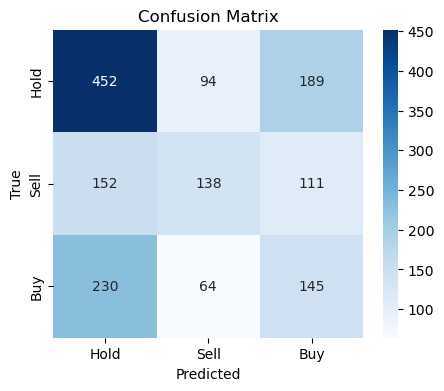

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
# Define class labels
labels = ['Hold', 'Sell', 'Buy']

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(total_conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()